# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [ ]:
%tensorflow_version 1.x
#!pip install tensorflow==1.15
import tensorflow as tf
print(tf.__version__)

#!pip install 'keras==2.1.6' --force-reinstall
#!pip install scipy==1.2.1

TensorFlow 1.x selected.
1.15.2


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#!pip install Cython
# !git clone https://github.com/cocodataset/cocoapi.git
# !pip install -U setuptools
# !pip install -U wheel
# !make install -C cocoapi/PythonAPI
!git clone https://github.com/pepper00023/mask_rcnn.git mask_rcnn

fatal: destination path 'mask_rcnn' already exists and is not an empty directory.


In [ ]:
import os
os.getcwd()
os.chdir('mask_rcnn')


In [ ]:
!ls

assets	    harajuku_f	LICENSE      mrcnn	requirements.txt  setup.cfg
demo.ipynb  images	MANIFEST.in  README.md	samples		  setup.py


In [ ]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
#sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
#import coco
from mrcnn import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "mask_rcnn/images")

Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [ ]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [ ]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [ ]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd ..

/content


In [ ]:
ls gdrive/MyDrive/NewThesis_Poonyawat_Woottisart/Dataset/european-street-fashion/

euro0.jpg    euro175.jpg  euro24.jpg   euro321.jpg  euro393.jpg
euro101.jpg  euro176.jpg  euro250.jpg  euro322.jpg  euro394.jpg
euro102.jpg  euro177.jpg  euro251.jpg  euro323.jpg  euro395.jpg
euro103.jpg  euro178.jpg  euro252.jpg  euro324.jpg  euro396.jpg
euro104.jpg  euro179.jpg  euro253.jpg  euro325.jpg  euro397.jpg
euro105.jpg  euro180.jpg  euro254.jpg  euro326.jpg  euro398.jpg
euro106.jpg  euro181.jpg  euro255.jpg  euro327.jpg  euro399.jpg
euro107.jpg  euro182.jpg  euro256.jpg  euro328.jpg  euro39.jpg
euro108.jpg  euro183.jpg  euro257.jpg  euro329.jpg  euro3.jpg
euro109.jpg  euro184.jpg  euro258.jpg  euro32.jpg   euro40.jpg
euro10.jpg   euro185.jpg  euro259.jpg  euro330.jpg  euro41.jpg
euro110.jpg  euro186.jpg  euro25.jpg   euro331.jpg  euro42.jpg
euro111.jpg  euro187.jpg  euro260.jpg  euro332.jpg  euro43.jpg
euro112.jpg  euro188.jpg  euro261.jpg  euro333.jpg  euro44.jpg
euro113.jpg  euro189.jpg  euro262.jpg  euro334.jpg  euro45.jpg
euro114.jpg  euro18.jpg   euro263.jpg  euro335.jp

In [ ]:
!ls

gdrive	mask_rcnn  mask_rcnn_coco.h5  sample_data


In [ ]:
!ls /content/mask_rcnn/mask_rcnn/

ls: cannot access '/content/mask_rcnn/mask_rcnn/': No such file or directory


In [ ]:
IMAGE_DIR = os.path.join(ROOT_DIR, "mask_rcnn/harajuku_f")
print(IMAGE_DIR)

/content/mask_rcnn/harajuku_f


In [ ]:
!ls /content/mask_rcnn/harajuku_f

image0.jpeg   image16.jpeg  image22.jpeg  image29.jpeg	image7.jpeg
image10.jpeg  image17.jpeg  image23.jpeg  image2.jpeg	image8.jpeg
image11.jpeg  image18.jpeg  image24.jpeg  image30.jpeg	image9.jpeg
image12.jpeg  image19.jpeg  image25.jpeg  image3.jpeg	image.jpeg
image13.jpeg  image1.jpeg   image26.jpeg  image4.jpeg	output
image14.jpeg  image20.jpeg  image27.jpeg  image5.jpeg
image15.jpeg  image21.jpeg  image28.jpeg  image6.jpeg


In [ ]:
os.listdir(IMAGE_DIR)

['image28.jpeg',
 'image3.jpeg',
 'image7.jpeg',
 'image6.jpeg',
 'image25.jpeg',
 'image26.jpeg',
 'image15.jpeg',
 'image19.jpeg',
 'image16.jpeg',
 'image0.jpeg',
 'image27.jpeg',
 'image4.jpeg',
 'output',
 'image21.jpeg',
 'image24.jpeg',
 'image13.jpeg',
 'image11.jpeg',
 'image20.jpeg',
 'image29.jpeg',
 'image18.jpeg',
 'image22.jpeg',
 'image1.jpeg',
 'image12.jpeg',
 'image10.jpeg',
 'image23.jpeg',
 'image8.jpeg',
 'image14.jpeg',
 'image5.jpeg',
 'image2.jpeg',
 'image.jpeg',
 'image17.jpeg',
 'image9.jpeg',
 'image30.jpeg']

In [ ]:
IMAGE_DIR

'/content/mask_rcnn/harajuku_f'

In [ ]:
# # Load a random image from the images folder
# IMAGE_DIR = os.path.join(ROOT_DIR, "gdrive/MyDrive/Colab Notebooks/mask_rcnn-master/mask_rcnn-master/harajuku_f")
# print(IMAGE_DIR)
# img_list = []
# for file_name in os.listdir(IMAGE_DIR):
#   try:
#     image = skimage.io.imread(os.path.join(IMAGE_DIR, file_name))

#     # file_names = next(os.walk(IMAGE_DIR))[2]
#     # image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

#     # Run detection
#     results = model.detect([image], verbose=0)

#     # Visualize results
#     r = results[0]
#     img_list.append(r)
#     print('Image: {} is successfully detected'.format(file_name))
#   except:
#     print('Image: {} CANNOT be used'.format(file_name))

# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                             class_names, r['scores'])

In [ ]:
def detection(img_dir):
  try:
    image = skimage.io.imread(img_dir)
    results = model.detect([image], verbose=0)
    
    return image, results[0]
  except:
    return None, None

# Image Cropping




In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
def cropping(det, img):

  num_piece = sum((det['class_ids']==1)&(det['scores']>0.995))
  temp_img_list = [np.zeros(shape=(img.shape[0], img.shape[1], 3)) for i in range(num_piece)]

  pt = 0
  for i in range(det['class_ids'].shape[0]):
    if((det['class_ids'][i]==1)&(det['scores'][i]>0.995)):
      temp_img_list[pt][:, :, 0] = r['masks'][:, :, i] * img[:, :, 0]
      temp_img_list[pt][:, :, 1] = r['masks'][:, :, i] * img[:, :, 1]
      temp_img_list[pt][:, :, 2] = r['masks'][:, :, i] * img[:, :, 2]
      pt = pt+1

  return cropping_main(temp_img_list)

In [ ]:
# temp_img_list = [np.zeros(shape=(image.shape[0], image.shape[1], 3)) for i in range(num_piece)]

In [ ]:
# pt = 0
# for i in range(r['class_ids'].shape[0]):
#   if(r['class_ids'][i]==True):
#     temp_img_list[pt][:, :, 0] = r['masks'][:, :, i] * image[:, :, 0]
#     temp_img_list[pt][:, :, 1] = r['masks'][:, :, i] * image[:, :, 1]
#     temp_img_list[pt][:, :, 2] = r['masks'][:, :, i] * image[:, :, 2]
#     pt = pt+1

In [ ]:
def cropping_main(temp_img_list):
  min_x = max_x = min_y = max_y = 0
  img_seg_list = []
  for z in range(len(temp_img_list)):
    h = temp_img_list[z].shape[0]
    w = temp_img_list[z].shape[1]
    for i in range(0, h):
      chk_px = 0
      for j in range(0, w):
        if(temp_img_list[z][i, j, 0]+temp_img_list[z][i, j, 1]+temp_img_list[z][i, j, 2]!=0):
          chk_px = 1
          break
      if(chk_px==1):
        min_i = i
        break
    for i in range(h-1, -1, -1):
      chk_px = 0
      for j in range(0, w):
        if(temp_img_list[z][i, j, 0]+temp_img_list[z][i, j, 1]+temp_img_list[z][i, j, 2]!=0):
          chk_px = 1
          break
      if(chk_px==1):
        max_i = i
        break

    for j in range(0, w):
      chk_px = 0
      for i in range(0, h):
        if(temp_img_list[z][i, j, 0]+temp_img_list[z][i, j, 1]+temp_img_list[z][i, j, 2]!=0):
          chk_px = 1
          break
      if(chk_px==1):
        min_j = j
        break
    for j in range(w-1, -1, -1):
      chk_px = 0
      for i in range(0, h):
        if(temp_img_list[z][i, j, 0]+temp_img_list[z][i, j, 1]+temp_img_list[z][i, j, 2]!=0):
          chk_px = 1
          break
      if(chk_px==1):
        max_j = j
        break
    print('{}, {}, {}, {}'.format(min_i, max_i, min_j, max_j))
    temp = np.zeros(shape=(max_i-min_i+1, max_j-min_j+1, 3))
    temp[:, :, 0] = temp_img_list[z][min_i:max_i+1, min_j:max_j+1, 0]
    temp[:, :, 1] = temp_img_list[z][min_i:max_i+1, min_j:max_j+1, 1]
    temp[:, :, 2] = temp_img_list[z][min_i:max_i+1, min_j:max_j+1, 2]
    img_seg_list.append(temp)
  return img_seg_list

In [ ]:
def cropping_alpha(det, img):

  num_piece = sum((det['class_ids']==1)&(det['scores']>0.995))
  temp_img_list = [np.zeros(shape=(img.shape[0], img.shape[1], 4)) for i in range(num_piece)]
  
  pt = 0
  for i in range(det['class_ids'].shape[0]):
    if((det['class_ids'][i]==1)&(det['scores'][i]>0.995)):
      temp_img_list[pt][:, :, 0] = r['masks'][:, :, i] * img[:, :, 0]
      temp_img_list[pt][:, :, 1] = r['masks'][:, :, i] * img[:, :, 1]
      temp_img_list[pt][:, :, 2] = r['masks'][:, :, i] * img[:, :, 2]
      temp_img_list[pt][:, :, 3] = r['masks'][:, :, i] * 255
      pt = pt+1
  
  # return temp_img_list
  return cropping_main_alpha(temp_img_list)

def cropping_main_alpha(temp_img_list):
  min_x = max_x = min_y = max_y = 0
  img_seg_list = []
  for z in range(len(temp_img_list)):
    
    h = temp_img_list[z].shape[0]
    w = temp_img_list[z].shape[1]
    print("h = {}, w = {}".format(h,w))
    for i in range(0, h):
      chk_px = 0
      for j in range(0, w):
        if(temp_img_list[z][i, j, 0]+temp_img_list[z][i, j, 1]+temp_img_list[z][i, j, 2]!=0):
          chk_px = 1
          break
      if(chk_px==1):
        min_i = i
        break
    for i in range(h-1, -1, -1):
      chk_px = 0
      for j in range(0, w):
        if(temp_img_list[z][i, j, 0]+temp_img_list[z][i, j, 1]+temp_img_list[z][i, j, 2]!=0):
          chk_px = 1
          break
      if(chk_px==1):
        max_i = i
        break

    for j in range(0, w):
      chk_px = 0
      for i in range(0, h):
        if(temp_img_list[z][i, j, 0]+temp_img_list[z][i, j, 1]+temp_img_list[z][i, j, 2]!=0):
          chk_px = 1
          break
      if(chk_px==1):
        min_j = j
        break
    for j in range(w-1, -1, -1):
      chk_px = 0
      for i in range(0, h):
        if(temp_img_list[z][i, j, 0]+temp_img_list[z][i, j, 1]+temp_img_list[z][i, j, 2]!=0):
          chk_px = 1
          break
      if(chk_px==1):
        max_j = j
        break
    print('{}, {}, {}, {}'.format(min_i, max_i, min_j, max_j))
    temp = np.zeros(shape=(max_i-min_i+1, max_j-min_j+1, 4))
    temp[:, :, 0] = temp_img_list[z][min_i:max_i+1, min_j:max_j+1, 0]
    temp[:, :, 1] = temp_img_list[z][min_i:max_i+1, min_j:max_j+1, 1]
    temp[:, :, 2] = temp_img_list[z][min_i:max_i+1, min_j:max_j+1, 2]
    temp[:, :, 3] = temp_img_list[z][min_i:max_i+1, min_j:max_j+1, 3]
    img_seg_list.append(temp)
  return img_seg_list

# Object Scaling

In [ ]:
import cv2

In [ ]:
# min_h = np.inf
# min_w = np.inf
# for i in range(len(img_seg_list)):
#   if(img_seg_list[i].shape[0]<min_h):
#     min_h = img_seg_list[i].shape[0]
#   if(img_seg_list[i].shape[1]<min_w):
#     min_w = img_seg_list[i].shape[1]

# img_scaling = [np.zeros(shape=(min_h, min_w, 3)) for i in range(len(img_seg_list))]

# for i in range(len(img_seg_list)):
#   img_scaling[i] = cv2.resize(img_seg_list[i], dsize=(min_w, min_h), interpolation = cv2.INTER_CUBIC)

In [ ]:
def scaling(img_seg_list):
  max_h = 0
  max_w = 0
  for i in range(len(img_seg_list)):
    if(img_seg_list[i].shape[0]>max_h):
      max_h = img_seg_list[i].shape[0]
    if(img_seg_list[i].shape[1]>max_w):
      max_w = img_seg_list[i].shape[1]

  img_scaling = [np.zeros(shape=(max_h, max_w, 3)) for i in range(len(img_seg_list))]

  for i in range(len(img_seg_list)):
    img_scaling[i] = cv2.resize(img_seg_list[i], dsize=(max_w, max_h), interpolation = cv2.INTER_CUBIC)
  
  return img_scaling

# Write result images

In [ ]:
ls harajuku_f/output

ls: cannot access 'harajuku_f/output': No such file or directory


In [ ]:
def write_img(img_scaling, out_dir, st_idx):
  for i in range(len(img_scaling)):
    IMAGE_DIR_out = os.path.join(out_dir, "test{:05d}.jpg".format(st_idx+i))
    skimage.io.imsave(IMAGE_DIR_out, img_scaling[i])

# Main Section

In [ ]:
ROOT_DIR

'/content'

In [ ]:
os.listdir(IMAGE_DIR)[0]

'image28.jpeg'

In [ ]:
file_name = os.listdir(IMAGE_DIR)[0]
img, r = detection(os.path.join(IMAGE_DIR, file_name))
temp_list = cropping(det=r, img=img)
img_scaling = scaling(img_seg_list=temp_list)

38, 250, 47, 128


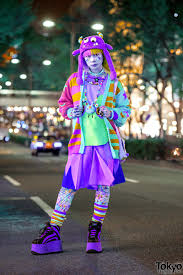

In [ ]:
cv2_imshow(img)

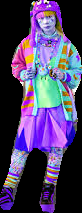

In [ ]:
cv2_imshow(img_scaling[0])

In [ ]:
img_scaling

[array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])]

In [ ]:
bgr = np.array(img_scaling[0][:,:,:3], dtype=np.uint8) # Channels 0..2
gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

*_, alpha = cv2.split(img_scaling[0])
# Some sort of processing...

bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
# alpha = img_scaling[0][:,:,3] # Channel 3
result = np.dstack([bgr, alpha])


gray_layer = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

# ... Your image processing

# Duplicate the grayscale image to mimic the BGR image and finally add the transparency
dst = cv2.merge((gray_layer, gray_layer, gray_layer, alpha))

error: ignored

In [ ]:
len(gray_layer)

213

In [ ]:
len(alpha), len(alpha[0])

(213, 82)

In [ ]:
len(bgr), len(bgr[0]), len(bgr[0][0])

(213, 82, 3)

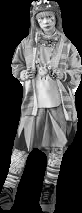

In [ ]:
cv2_imshow(bgr)

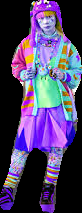

In [ ]:
cv2_imshow(img_scaling[0])

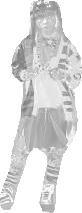

In [ ]:
cv2_imshow(result)

In [ ]:
result

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0.],
        [0., 0.

In [ ]:
# IMAGE_DIR = os.path.join(ROOT_DIR, "gdrive/MyDrive/Colab Notebooks/mask_rcnn-master/mask_rcnn-master/report")
# IMAGE_DIR_out = os.path.join(ROOT_DIR, "gdrive/MyDrive/Colab Notebooks/mask_rcnn-master/mask_rcnn-master/report/output")

IMAGE_DIR = os.path.join(ROOT_DIR, "gdrive/MyDrive/NewThesis_Poonyawat_Woottisart/Dataset/thai-street-fashion")
IMAGE_DIR_out = os.path.join(ROOT_DIR, "gdrive/MyDrive/NewThesis_Poonyawat_Woottisart/Dataset/thai-street-fashion-output")

print(IMAGE_DIR)
# img_list = []
idx = 0
for file_name in os.listdir(IMAGE_DIR):
  try:
    img, r = detection(os.path.join(IMAGE_DIR, file_name))
    temp_list = cropping(det=r, img=img)
    img_scaling = scaling(img_seg_list=temp_list)
    write_img(img_scaling=img_scaling, out_dir=IMAGE_DIR_out, st_idx=idx)
    idx = idx+len(img_scaling)
    print('Image: {} is successfully detected'.format(file_name))
  except:
    print('Image: {} CANNOT be used'.format(file_name))

In [ ]:
# pip install gitpython

In [ ]:
# from git import Repo

# # repo_dir = 'mask_rcnn'
# repo = Repo()
# file_list = [
#     'harajuku_f/output/test2.jpg',
# ]
# commit_message = 'Add output image'
# repo.index.add(file_list)
# repo.index.commit(commit_message)
# repo.git.push()

In [ ]:
skimage.io.imsave('/content/gdrive/MyDrive/Colab Notebooks/mask_rcnn-master/mask_rcnn-master/harajuku_f/output/output_1.jpg', img_scaling[1])

In [ ]:
# from github import Github
# from credentials import username, password
# import pygit2
# from git import Repo
# import shutil
# import subprocess

# name = input("Name of iOS project: ") # repo name
# description = input("github description: ") 

# def createGithubRepo(name, description):
#     g = Github(username, password)
#     gituser = g.get_user()
#     repo = gituser.create_repo(name) 
#     repo.create_file("README.md", "init commit", description)
#     return repo.git_url 

# def clone(url, destination):
#     repoClone = pygit2.clone_repository(url, destination)
#     repoClone.remotes.set_url("origin", url)
#     return repoClone


# def basicPushToGithub(pathToRepo, commitMessage, paths):
#     repo = Repo(pathToRepo)
#     repo.index.add(paths)
#     repo.index.commit(commitMessage)
#     repo.git.push()

# createGithubRepo(name, description)
# url = 'https://github.com/<userpath>/'+name+'.git'
# repoClone = clone(url, destination)
# basicPushToGithub(destination, 'Project added', [destination + name])